# Assignment 2 - Sentiment Analysis of Tweets (20 marks) - Update 18 April 2017

In this assignment you will use statistical classifiers for the task of predicting the polarity (positive, negative) of opinions expressed in tweets. This is a type of **sentiment analysis** which is becoming increasingly useful given the strong influence of the opinions posted in social media nowadays.

To learn more about sentiment analysis and some of its techniques you can read chapter 7 of this book:

* [Maynard et al. Natural Language Processing for the Semantic Web. Morgan & Claypool, 2016.](http://www.morganclaypool.com/doi/10.2200/S00741ED1V01Y201611WBE015)

For this assignment we will use the Twitter Sentiment Analysis Training Corpus described in [this blogpost](http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/), which contains over 1.5 million tweets annotated with the sentiment polarity: 0 for negative sentiment, and 1 for positive sentiment.

**Note that this corpus is much larger than the data that we have used in the workshop exercises. Be careful when you process it. If your code is not efficient, you will easily overwhelm the resources in your computer. To do the tasks, it is best that your computer has at least 16GB of RAM (the computers in E6A123 have 16GB of RAM). It would be wise if you did your first tests for debugging with a small portion of the data.**


Download the file SentimenAnalysisDataset.zip, unzip the file and place the resulting CSV (comma-separated-value) file in the same folder as this notebook. The unzipped file takes 150MB of space, so there is no problem to load the code into the memory of a modern computer. The following code uses Python's `csv` module to load the data and prints the first row and the total number of rows.

<font color="red"> All added texted (Question answers) is in red to standout</font>

In [1]:
import nltk
import sklearn
import csv

In [2]:
with open('Sentiment Analysis Dataset.csv', encoding="utf8") as f:
    reader = csv.reader(f)
    print("Header line: %s" % next(reader))
    annotated_data = [r for r in reader]
print(annotated_data[0])
print("Total number of rows:", len(annotated_data))

Header line: ['\ufeffItemID', 'Sentiment', 'SentimentSource', 'SentimentText']
['1', '0', 'Sentiment140', '                     is so sad for my APL friend.............']
Total number of rows: 1578614


As you can see, each element in the list `annotated_data` is a list with the following information:

* item ID
* Sentiment (0 if negative, 1 if positive)
* Sentiment source (we can ignore this information for this assignment)
* Text of the tweet

To make this exercise more manageable, we will use only 500,000 tweets taken randomly from the annotated data:

In [3]:
import random
random.seed(1234)
random.shuffle(annotated_data)
annotated_data = annotated_data[:500000]

If you look at the tweets you will see that there are words in all uppercase characters, and that information may be useful. Therefore, **in the exercises below it is probably best that you do not convert the words to uppercase or lowercase**.

### Exercise 1 (1 mark) - Split the data
Split the data into a training set, a dev-test set, and a test set. Use the following ratio for splitting the data:

* Training set: 80%
* Dev-test set: 10%
* Test set: 10%

In [4]:
# Calculate the thresholds
threshold1 = int(len(annotated_data) * 0.8)
threshold2 = int(len(annotated_data) * 0.9)

# Split the annotated data into sets
training_set = annotated_data[:threshold1] # First 80%
devtest_set = annotated_data[threshold1:threshold2] # 80% to 90%
test_set = annotated_data[threshold2:] # 90% to 100%

### Exercise 2 (1 mark) - Check that the data are balanced
Print the percentage of positive and negative sentiments in each partition, and check that they are similar.

In [5]:
#Print out the positive and negative sentiment percentages of a dataset
def check_sentiment(dataset):  
    
    positive_count = 0
    negative_count = 0
    
    for (_, s, _, _) in dataset:
        if (int(s) == 0): negative_count += 1
        elif (int(s) == 1): positive_count += 1
              
    positive_percent = (float(positive_count) / len(dataset)) * 100
    negative_percent = (float(negative_count) / len(dataset)) * 100
    print("    [%s%% positive]"%(round(positive_percent,2)))
    print("    [%s%% negative]"%(round(negative_percent,2)))
    
print("Training set [%s tweets]"%len(training_set))
check_sentiment(training_set)
print("DevTest set [%s tweets]"%len(devtest_set))
check_sentiment(devtest_set)
print("Test set [%s tweets] "%len(test_set))
check_sentiment(test_set)

Training set [400000 tweets]
    [49.99% positive]
    [50.01% negative]
DevTest set [50000 tweets]
    [49.81% positive]
    [50.19% negative]
Test set [50000 tweets] 
    [50.19% positive]
    [49.81% negative]


### Exercise 3 (2 marks) - Some simple data exploration
Answer the following questions. In your solution you need to include the code that you used to answer the questions. To find the answers to all of the questions below, **do not convert the text to lowercase**.

1. (1 mark) What is the size of the entire vocabulary in the training set?
<font color="red"><p>The size of the entire vocabulary set for this particular training set is 346623</p></font>
2. (1 mark) In the training set, what words appear in the largest number of tweets with positive sentiment? What words appear in the largest number of tweets with negative sentiment?
<font color="red"><p>Ignoring any punctunaction that appears as a result of the word tokenizer, the most common words in both positive and negative tweets mostly consist of stopwords (it, the, to, a, is). After those words we have some of the more expected words such as sad/bad in negative tweets and good/great in positive tweets, The top 100 for both can be found below in the output.</p></font>

In [6]:
from nltk.tokenize import word_tokenize
from collections import Counter

all_words = []
pos_words = []
neg_words = []

#Build up the word lists
for (_, s, _, txt) in training_set:
    words = word_tokenize(txt)
    all_words += words
    #Keep track of pos/neg word counts (Convert to set so words are only added once, even if they occur twice in the same tweet)
    if (int(s) == 0):
        neg_words += set(words)
    else:
        pos_words += set(words)

#Convert all words to a set removing any duplicates resulting in a vocabulary
vocabulary = set(all_words)

#Create counters for the positive words and the negative words
pos_words_counter = Counter(pos_words)
neg_words_counter = Counter(neg_words)

#Print out relevant information
print("Word count: %d"%(len(all_words)))
print("Vocabulary size: %d"%(len(vocabulary)))
print("Most common positive words")
print(pos_words_counter.most_common(100))
print("Most common negative words")
print(neg_words_counter.most_common(100))

Word count: 6585540
Vocabulary size: 346623
Most common positive words
[('@', 111256), ('!', 71085), ('.', 66110), ('the', 51962), ('to', 51905), ('I', 50816), (',', 49224), ('a', 41974), ('you', 36111), ('and', 31244), ('it', 27499), ('for', 26849), ('my', 25949), ('...', 25079), ('is', 24244), ('in', 22509), ('?', 21713), ('i', 21548), ("'s", 21202), ('of', 21020), ('on', 18783), ('that', 17247), (':', 17064), (';', 16398), ('me', 15772), ('with', 15414), ('&', 13916), ('have', 13913), ("'m", 13177), ('so', 13148), ("n't", 12791), ('be', 12609), ('http', 11422), ('just', 11414), ('good', 11214), ('at', 10908), ('was', 10600), ('are', 10132), ('do', 10068), ('-', 9952), ('day', 9826), ('but', 9813), ('your', 9791), ('love', 9482), ('up', 9069), ('this', 9032), ('all', 8864), ('out', 8862), ('like', 8694), ('now', 8553), ('get', 7896), ('not', 7197), ('got', 6758), ('from', 6668), (')', 6513), ('time', 6509), ('today', 6480), ('too', 6458), ('will', 6409), ('going', 6287), ('can', 6280

### Exercise 4 (2 marks) - One-hot encoding for Naive Bayes in NLTK

Using the training set, design a feature extractor that uses one-hot encoding with the entire vocabulary in the training set. Use the feature extractor to train a Naive Bayes classifier in NLTK and report the accuracy of the classifier using the test set.

In [7]:
#Extract the features using the vocabulary, performing one hot encoding for any words in the vocabulary set
def extract_features(words):
    result = dict()
    for w in word_tokenize(words):
        result["%s"%w] = (w in vocabulary)
    return result

#Construct feature sets using the feature extraction func
training_features = [(extract_features(w), s) for (_, s, _, w) in training_set]
test_features = [(extract_features(w), s) for (_, s, _, w) in test_set]

#Train a classifer using the training set and report the accuracy using the test set
classifier1 = nltk.NaiveBayesClassifier.train(training_features)
print("%s accuracy"%(nltk.classify.accuracy(classifier1, test_features)))

0.76926 accuracy


### Exercise 5 (2 marks) - One-hot encoding of most informative features

Find the 2000 most informative features with the help of the NLTK classifier of exercise 4 (read [chapter 6 of the NLTK book](http://www.nltk.org/book/ch06.html) for help on how to find the most informative features). Use NLTK to build a new Naive Bayes classifier that uses these 2000 most informative features, train it on the training set, and report the accuracy on the test set. 

In [8]:
#Get the 2000 most informative features (mif) as words from the previous classifier
mif2000 = set([w for (w, c) in classifier1.most_informative_features(2000)])

#Extract features using the most informative words set, performing one hot encoding for any words in the most informative features set
def extract_features_mif(words):
    result = dict()
    for w in word_tokenize(words):
        result["%s"%w] = (w in mif2000)
    return result

#Construct feature set using the feature extraction function
training_features_mif = [(extract_features_mif(w), s) for (_, s, _, w) in training_set]

#Train a classifer and report the accuracy
classifier2 = nltk.NaiveBayesClassifier.train(training_features_mif)
print("%s accuracy"%(nltk.classify.accuracy(classifier2, test_features)))

0.65508 accuracy


### Exercise 6 (2 marks) - Tfidf for Naive Bayes in Scikit-Learn
Using Scikit-Learn, generate the tf.idf matrix of the training set. **Use the defaults of `sklearn`'s `TfidfVectorizer` except for `lowercase`, which you must set to `False`**. [sklearn documentation for TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) With this matrix, train an `sklearn` Naive Bayes classifier using the training set and report the accuracy on the test set.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

#Default Vectorizer with lowercase set to false
tfidf_vect = TfidfVectorizer(lowercase=False)

#Build train and test tfidf matrix
tfidf_train = tfidf_vect.fit_transform([w for (_, _, _, w) in training_set])
tfidf_test = tfidf_vect.transform([w for (_, _, _, w) in test_set])
tfidf_devtest = tfidf_vect.transform([w for (_, _, _, w) in devtest_set])

#Fit the TF-IDF matrix to a multinomial naive bayes classifier
tfidf_classifier = MultinomialNB()
tfidf_classifier.fit(tfidf_train, [s for (_, s, _, _) in training_set])

training_set_labels = [s for (_, s, _, _) in training_set]
test_set_labels = [s for (_, s, _, _) in test_set]
devtest_set_labels = [s for (_, s, _, _) in devtest_set]

#Get the accuracy score compared to the test set
print("%s accuracy"%(accuracy_score(test_set_labels, tfidf_classifier.predict(tfidf_test))))

0.76956 accuracy


### Exercise 7 (2 marks) - Analysis of Results
Analyse the results of all the classifiers from the previous exercises, and answer these questions. In all answers you must include any code that you used to answer the questions, the output of the code. Your answer must also include text formatted in Markdown where you write your interpretation of the output and how this interpretation answer the questions.

1. (1 mark) Did you observe any overfitting in any of the classifiers? How did you determine whether they are overfitting?
<font color="red"><p>There does appear to be some overfitting present in the classifiers, this was determined by comparing the accuracy of the training and test data sets (In the graph shown created below using matplotlib), which shows the training data set outperforming the test set by a noticable amount (~87% to ~75%), indicating that there is some overfitting occuring. Similar overfitting can also be seen in the accuracy of classifier used in exercise 6 with the training set having much better overall accuracy, shown below the graph.</p></font>
2. (1 mark) Do we have too little training data, or do we have too much training data for these classifiers?
<font color="red"><p>There is a plenty of training data to be used (Currently 500000 tweets spread across 3 sets with around 400000 used for the training set), as seen below in the graph there is little improvement in accruacy as the size of the data set grows beyond around 10000 which indicates we could use a smaller set of training data if we were concerned about performance.</p></font>

In [10]:
#Collect multiple samples of the accuracy at varying size (Takes a while to run)
training_set_accuracy = []
test_set_accuracy = []
nsamples = range(10,50000,5000)
for n in nsamples:
    classifier = nltk.NaiveBayesClassifier.train(training_features)
    training_set_accuracy.append(nltk.classify.accuracy(classifier,training_features[:n]))
    test_set_accuracy.append(nltk.classify.accuracy(classifier,test_features[:n]))

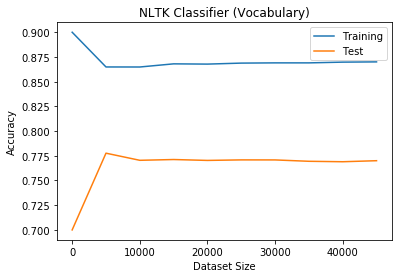

In [11]:
#Draw Graph
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(nsamples, training_set_accuracy, label='Training')
plt.plot(nsamples, test_set_accuracy, label='Test')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.title('NLTK Classifier (Vocabulary)')
plt.legend()

In [12]:
#Print accuracies for exercise 6
print("Test Set [%s accuracy]"%(accuracy_score(test_set_labels, tfidf_classifier.predict(tfidf_test))))
print("DevTest Set [%s accuracy]"%(accuracy_score(devtest_set_labels, tfidf_classifier.predict(tfidf_devtest))))
print("Training Set [%s accuracy]"%(accuracy_score(training_set_labels, tfidf_classifier.predict(tfidf_train))))

Test Set [0.76956 accuracy]
DevTest Set [0.76358 accuracy]
Training Set [0.856125 accuracy]


### Exercise (8 marks) - Improve the System and Final Analysis
This exercise is open ended. Your goal is to perform a more detailed error analysis and identify ways to improve the classification of sentiments by adding or changing the features. Read, for example, Chapter 7 of the book by Maynard et al, or do your own research using the library or the Web. To obtain top marks in this part, you need to include the following in the answer:

1. An error analysis of the previous systems.
2. Text explaining what sort of modifications you would want to implement, and justify why these would be useful modifications.
3. An implementation of the improved classifier.
4. An evaluation of the results and comparison with the previous classifiers. You must explain what is the best system. In your explanation, include all factors that you used to decide which system is best.
5. Text explaining what further changes would possibly improve the classifier and why.

All this information should be inserted in this notebook below this question. The information should be structured in sections and it must be clear and precise. The explanations should be convincing. Below is a possible list of section headings. These sections are just a guideline. Feel free to change them, but make sure that they are informative and relevant.

### 1. Error Analysis

<font color="red">
<p>
The code for the error analysis can be found in the cell below. 
</p>
<p>
The first part of the error analysis is a confusion matrix of the classifier that is part of exercise 4, it shows some valuable information namely that there is a significant difference in the correct classification accuracy between negative and positive tweets. Negative tweets have a correct classification rate of approximately 42 percent compared to positive tweets only having a correct classification rate of 33 percent. It also shows a significant different between the amount of incorrectly classified tweets, with nearly double the number of positive tweets being incorrectly classified as negative tweets compared to the reverse.
</p>
<p>
The second part of the error analysis is a full classification report of the sklearn naïve Bayes classifier (In combination with the TF-IDF vectorizer) that is part of exercise 6. In the classification, it shows that the primary deficient part is occurring in regard to the precision of negative tweets and the recall of positive tweets, which is similar to the errors in the classifier from exercise 4. Providing addition context (better selection/additional features) to the tweets should help alleviate these problems.
</p>
<p>
As Noted above in exercise 7 there does also appear to be a fairly large amount of overfitting present in the classifier, which should ideally be reduced.
</p>
</font>

### 2. Explanation of the Proposed New Classifier

<font color="red">
<p>
There are several possible modifications that I believe would improve the accuracy of the classifier. To start with I will base the new classifier off the TF-IDF approach as it produced the best overall accuracy in the above exercises. This will then be extended into a linear SVC (Part of sklearn library), the decision to use a linear SVC over a naïve Bayes is mostly due to various research articles recommending it as the best approach to classification/sentiment analysis (Along with mentions in the lecture notes).
</p>
<p>
The primary modification to the input will be expanding from the use of singular words to n-grams. This should provide a boost to accuracy since it will allow for an improvement to the number of potentially informative features that can be used to determine the sentiment of a tweet, differing size of n-grams will be explored to determine which offers the best accuracy. 
</p>
<p>
Another modification that could be used to improve accuracy is something that is particularly relevant in the domain of sentiment analysis on tweets is the casual nature of them, the default word tokenize has a limited ability to parse many casual terms such as emoticons (For instance a smiley face emoticon “:)” would likely indicate a positive sentiment). Switching out the default word tokenizer for NLTK casual word tokenizer should offer some improvement due to this improvement in parsing ability.
</p>
<p>
Some other possible modifications that will be explored include filtering features that occur to extremely commonly or are extremely uncommon, which will be likely be implemented through the use of max_df / min_df which can control filter out words that don’t have a high/low document frequency. In exercise 4 it showed that only a small segment of the most informative features lower the overall accuracy so that approach will be avoided, instead opting for filtering out the least informative features (Words that are extremely common and are likely just noise).
</p>
</font>

### 3. Code of the Proposed New Classifier

<font color="red">
<p>
The code for the proposed new classifier is in the cell below the error analysis (Along with some analysis on the resulting classification)
</p>
</font>

### 4. Evaluation and Comparison

<font color="red">
<p>
Overall in comparison with the classifiers in exercise 4/5/6, a decent improvement in the accuracy occurred. The accuracy in the initial classifiers being around 76% with the new classifier achieving around 82%. There is also a classification report run on the classifier (for both the test and devtest sets) which shows the improvement in the areas that were failing in particular the recall and precision of both negative and positive tweets now appears to be fairly well balanced, which is likely a result the increase in the amount of information bigrams/casual tokens etc. that are provided to the classifier. The classification report also shows that there is still amount of overfitting occuring with the training set achieving an accuracy in the high 90s.
</p>
</font>

### 5. Final Conclusions and Possible Improvements

<font color="red">
<p>
The biggest gains in accuracy came from transitioning the word tokenizer over to the casual tokenizer and the utilizing the linear SVC (Other algorithms were explored in but this one offer the best), both providing several points in accuracy. Introduction bigrams also provide a decent boost and subsequently trigrams providing another boost (although smaller), quad-grams were also explored but they offered little boost. 
</p>
<p>
Interestingly changing over to a version that converts everything to lower case (thus removing any case sensitivity) also offered a decent increase in accuracy, this is likely due to the benefits of being able to associate words with each other regardless of their case out weighing the benefit of slightly more context with case sensitive words.
</p>
<p>
Several different max_df and min_df settings were explored, whilst some of these did improve the accuracy to one set of data it would also reduce the accuracy of another set, indicating that these settings for the most part are sensitivity to the data being fed. I did find some improvement with limited filtering a setting of max_df=40000 (Filtering out anything occuring in more than 40000 tweets, approx 10% of the training set) which improved the accuracy of the classification on both the devtest and test set.
</p>
<p>
One possible improvement that could be implemented that was not could be the introduction of would be training a POS tagger and tagging every word with the relevant POS, providing more information on the context of words and potentially improving the accuracy, as a result of the increased context provided with every word.
</p>
</font>

In [13]:
#Error Analysis

from sklearn.metrics import classification_report

#Confusion matrix Exercise 4 Classifier
print("Exercise 4 Confusion Matrix")
devtest_features = [(extract_features(w), s) for (_, s, _, w) in devtest_set]
devtest_predictions = [classifier.classify(f) for (f, l) in devtest_features]
devtest_labels = [s for (_, s, _, w) in devtest_set]
nltk_cm = nltk.ConfusionMatrix(devtest_labels, devtest_predictions)
print(nltk_cm.pretty_format(sort_by_count=True, show_percents=True))

#Classification Report Exercise 6 Classifier
print("Exercise 6 Classifier")
print("Test Set [%s accuracy]"%(accuracy_score(test_set_labels, tfidf_classifier.predict(tfidf_test))))
print(classification_report(test_set_labels, tfidf_classifier.predict(tfidf_test)))

Exercise 4 Confusion Matrix
  |      0      1 |
--+---------------+
0 | <42.7%>  7.5% |
1 |  15.9% <33.9%>|
--+---------------+
(row = reference; col = test)

Exercise 6 Classifier
Test Set [0.76956 accuracy]
             precision    recall  f1-score   support

          0       0.74      0.84      0.78     24907
          1       0.81      0.70      0.75     25093

avg / total       0.77      0.77      0.77     50000



In [14]:
#Proposed New Classifier
from nltk.tokenize import casual_tokenize
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

#Setup the tf-idf matrix with the relevant varaibles
tfidf = TfidfVectorizer(lowercase=True, ngram_range=(1, 3), tokenizer=casual_tokenize, max_df=40000)

#Fit fit training data, and transform test and devtest
training_set_tfidf = tfidf.fit_transform([w for (_, _, _, w) in training_set])
test_set_tfidf = tfidf.transform([w for (_, _, _, w) in test_set])
devtest_set_tfidf = tfidf.transform([w for (_, _, _, w) in devtest_set]) 

#Collect all the correct labels (For classification and training)
training_set_label = [s for (_, s, _, _) in training_set]
test_set_labels = [s for (_, s, _, _) in test_set]
devtest_set_labels = [s for (_, s, _, _) in devtest_set]

#Setup the linearSVC and train it using the training tf-idf matrix and labels
classifier = LinearSVC(loss="hinge")
classifier.fit(training_set_tfidf, training_set_label)

#Print out classifcation reports of the test, devtest using the newly trained classifier (Along with the accuracy)
print("Test Set [%s accuracy]"%(accuracy_score(test_set_labels, classifier.predict(test_set_tfidf))))
print(classification_report(test_set_labels, classifier.predict(test_set_tfidf)))

print("DevTest Set [%s accuracy]"%(accuracy_score(devtest_set_labels, classifier.predict(devtest_set_tfidf))))
print(classification_report(devtest_set_labels, classifier.predict(devtest_set_tfidf)))

print("Training Set [%s accuracy]"%(accuracy_score(training_set_label, classifier.predict(training_set_tfidf))))
print(classification_report(training_set_label, classifier.predict(training_set_tfidf)))

Test Set [0.82134 accuracy]
             precision    recall  f1-score   support

          0       0.81      0.84      0.82     24907
          1       0.83      0.80      0.82     25093

avg / total       0.82      0.82      0.82     50000

DevTest Set [0.82482 accuracy]
             precision    recall  f1-score   support

          0       0.81      0.84      0.83     25096
          1       0.84      0.81      0.82     24904

avg / total       0.83      0.82      0.82     50000

Training Set [0.9687375 accuracy]
             precision    recall  f1-score   support

          0       0.96      0.97      0.97    200053
          1       0.97      0.96      0.97    199947

avg / total       0.97      0.97      0.97    400000



# Submission of Results

Your submission should consist of this jupyter notebook with all your code and explanations inserted in the notebook. The notebook should contain the output of the runs so that it can be read by the assessor without needing to run the output.

Examine this notebook so that you can have an idea of how to format text for good visual impact. You can also read this useful [guide to the markdown notation](http://daringfireball.net/projects/markdown/syntax), which explains the format of the text.

Late submissions will have a penalty of **4 marks deduction per day late**.

Each question specifies a mark. The final mark of the assignment is the sum of all the individual marks, after applying any deductions for late submission.

By submitting this assignment you are acknowledging that this is your own work. Any submissions that breach the code of academic honesty will be penalised as per the [academic honesty policy](https://staff.mq.edu.au/work/strategy-planning-and-governance/university-policies-and-procedures/policies/academic-honesty).